In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

c:\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Python312\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.30.2 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.

In [2]:
df = pd.read_csv("ETH_2017-2024.csv")

print(df.shape)

print(df.head())

(2700, 3)
         Date  Closing Price      Volume
0  2017-11-09     320.884003   893249984
1  2017-11-10     299.252991   885985984
2  2017-11-11     314.681000   842300992
3  2017-11-12     307.907990  1613479936
4  2017-11-13     316.716003  1041889984


In [3]:
value_column = "Closing Price"

In [4]:
scaler = MinMaxScaler()
df[[value_column]] = scaler.fit_transform(df[[value_column]])

df = df.drop("Date", axis=1)
df = df.drop("Volume", axis=1)
df.index = df.index * 0.1 + 1

df

,Closing Price
1.0,0.050040
1.1,0.045464
1.2,0.048727
1.3,0.047295
1.4,0.049158
...,...
270.5,0.405698
270.6,0.383096
270.7,0.368675
270.8,0.364211


In [ ]:
cutoff = int(len(df) * 0.8)


# train data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]




X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# I used the scaler after the Train/Test split to avoid data leakage
scaler = MinMaxScaler()

y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1)) # AI helped me here because I was using fit_transform here but then there was a crack in the data (I saw it in the visualisation


X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

n_features = 1

train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

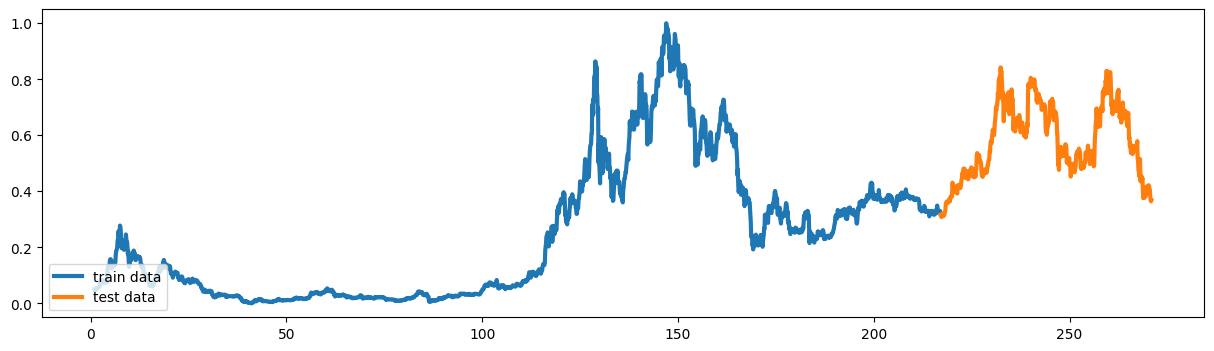

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

look_back  = 16
batch_size = 1

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

In [8]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

mc = ModelCheckpoint('best_model_lstm_eth.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

n_neurons  = 64

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(LSTM(n_neurons, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(train_generator, epochs=150, verbose=1, validation_data=test_generator, callbacks=callback_list)

Epoch 1/150


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2144/2144 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 2/150
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 9.7106e-04 - val_loss: 9.6743e-04
Epoch 3/150
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 6.9711e-04 - val_loss: 7.3326e-04
Epoch 4/150
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 5.9317e-04 - val_loss: 9.6558e-04
Epoch 5/150
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.8882e-04 - val_loss: 6.2021e-04
Epoch 6/150
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.4522e-04 - val_loss: 7.8148e-04
Epoch 7/150
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.5464e-04 - val_loss: 4.9768e-04
Epoch 8/150
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.3530e-04 - val_loss: 5.3187e-04
Epoch 9/150
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 3.8761e-04 - val_loss: 4.7364e-04
Epoch 10/150
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 4.1408e-04 - val_loss: 4.9652e-04
Epoch 11/150
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 8s 4

<Axes: >

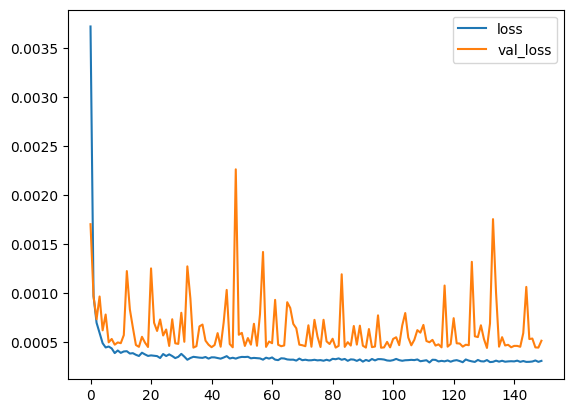

In [9]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [10]:
from keras.models import load_model
model = load_model("best_model_lstm_eth.keras")

In [11]:
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

2144/2144 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.5598e-04
Training loss: 0.00025598297361284494
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.4024e-04  
Testing loss: 0.00044023990631103516


In [12]:
test_predictions  = model.predict(test_generator)

524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [13]:
actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")


print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
2.53 %

MAE
0.01 units

MSE
0.0 units^2

RMSE:
0.02 units

R-squared:
0.97


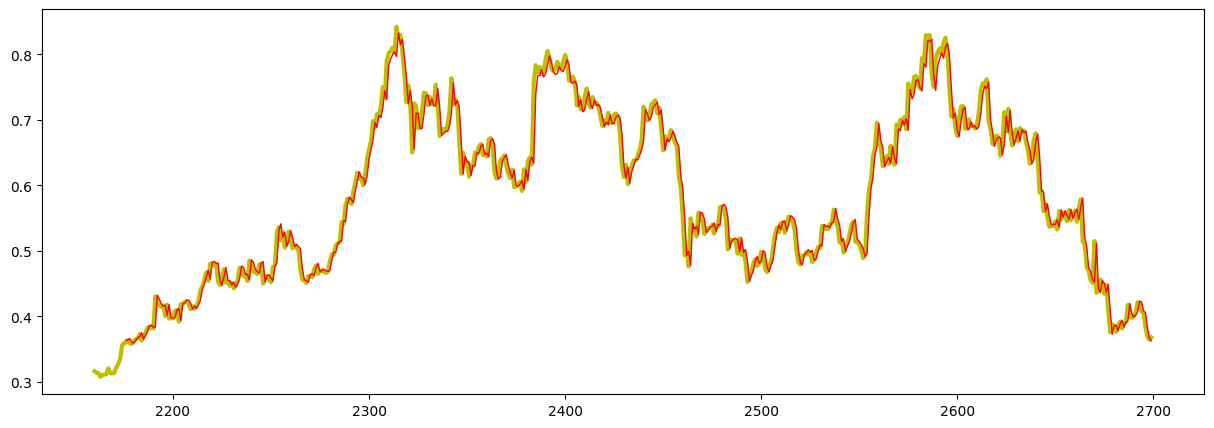

In [ ]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
plt.show()


# There is still data leakage even if I apply the MinMaxScaler after the split. I dont understand why because I used the code from the github notebooks

In [15]:

result = model.evaluate(train_generator)
print(f"Training loss: {result}")

result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

2144/2144 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.5598e-04
Training loss: 0.00025598297361284494
524/524 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.4024e-04
Testing loss: 0.00044023990631103516


In [16]:
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

for i in range(1000): 
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

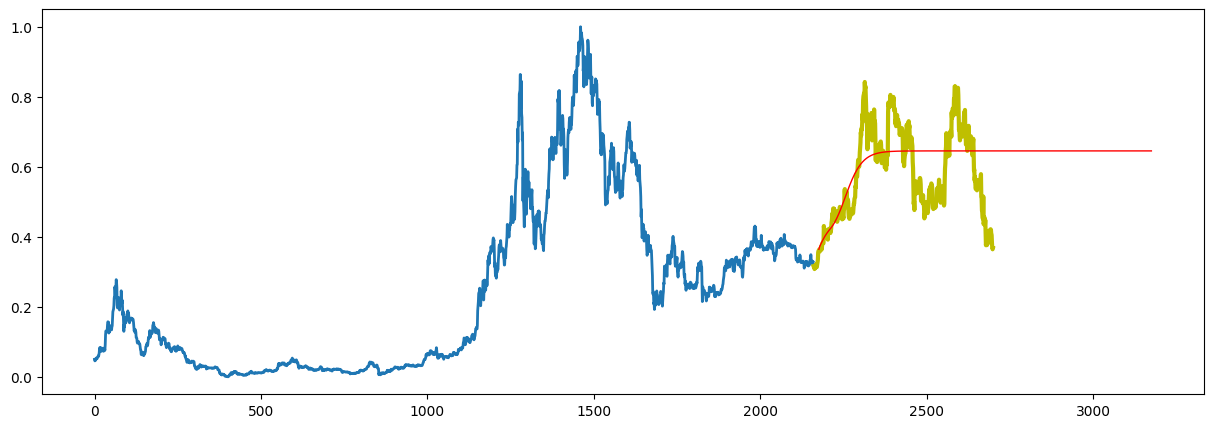

In [ ]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
plt.show()

# the shortterm prediction is quite good here as well